# Vgg model from scratch with Statefarm Distracted Driver data

#### To do before running the notebook
- Download data and unzip

From looking at the statefarm-sample nb I saw that the training and the validation set should contain different drivers... I definitely did not do that first time round... So how do I do that... I guess I need to look at driver_imgs_list.csv. So this should be my first step when I actually start coding.

Ok, so this really is a massive problem! Use 20% of drivers!

Try http://forums.fast.ai/t/statefarm-kaggle-comp/183/21

#### From Lesson 3
Underfitting versus overfitting
- Underfitting: validation acc higher than training acc --> It seems this is actually happening. We can reduce drop out for that!
- (YES) We can precompute the convolutional layers to make the network faster. To do that extract the conv layers and make them their own model and use those to get predictions for the validation and test set!
- Then use those as an input to all the other layers we add upon that.
- We can also use the preloaded weights, but we have to half them to account for the missing dropout...
- Then compile the new model (same architecture with dropout = 0) using RMSprop as an optimizer and load the weights, then train and this task is done!

Now to reduce overfitting (train acc > valid acc) This should be the first goal!
- Data augmentation
    - use the keras image.ImageDataGenerator with arguments and pass it to get_batches, and train with the new data
    - But now we cannot precompute the conv layer (let's just ignore that anyway)
- Batch normalization (It's the shit and I should use it!)
    - Ok, this is now a little more complex. Converting the VGG model to VGG + BN
    - But now he is using the precomputed layers again!?
    - Ok, do some training with the regular data
- Then add the two
    - I need to look closely at how this is done...
    - Code it and understand it!

In [1]:
# Path containing unzipped data
#  DATA_DIR = '/Users/stephanrasp/repositories/courses/data/statefarm/'   # Mac
DATA_DIR = '/home/ubuntu/courses/data/statefarm/'   # AWS

#### Step 1: Set up folder structure with sample data


**THIS IS NOW DONE IN A SEPARATE NOTEBOOK**

- The folder structure is already good, each category has its own directory. This means we need to do:
- Create validation set with different drivers from the train set!
- Then create sample 

```
DATA_DIR/
    test/
        unknown/ - Need to move those
            img_<num>.jpg
    train/
        c0/
        ...
        c9/
            img_<num>.jpg
    [We need to create and move files]
    valid/
        c0/
        ...
        c9/
            img_<num>.jpg - valid_size
    [And then copy]
    sample/
        train/
            c0/
            ...
            c9/
                img_<num>.jpg - sample_train_size
        valid/
            c0/
            ...
            c9/
                img_<num>.jpg - sample_valid_size
        test/
            unknown/ - Need to move those
                img_<num>.jpg
```

In [2]:
# How much data is there in each category
import glob
for i in range(10):
    print('Category %i contains %i test imgs' %(i, len(glob.glob(DATA_DIR + '/train/c%i/*' % i))))
    print('Category %i contains %i valid imgs' %(i, len(glob.glob(DATA_DIR + '/valid/c%i/*' % i))))
print('Test set contains %i' %(len(glob.glob(DATA_DIR + '/test/unknown/*'))))

Category 0 contains 2246 test imgs
Category 0 contains 243 valid imgs
Category 1 contains 2021 test imgs
Category 1 contains 246 valid imgs
Category 2 contains 2066 test imgs
Category 2 contains 251 valid imgs
Category 3 contains 2090 test imgs
Category 3 contains 256 valid imgs
Category 4 contains 2057 test imgs
Category 4 contains 269 valid imgs
Category 5 contains 2045 test imgs
Category 5 contains 267 valid imgs
Category 6 contains 2064 test imgs
Category 6 contains 261 valid imgs
Category 7 contains 1768 test imgs
Category 7 contains 234 valid imgs
Category 8 contains 1661 test imgs
Category 8 contains 250 valid imgs
Category 9 contains 1917 test imgs
Category 9 contains 212 valid imgs
Test set contains 79727


In [3]:
DATA_DIR_SAMPLE = DATA_DIR + 'sample/'

#### Step 2: Try loading and visualizing the data

In [4]:
sample_file = glob.glob(DATA_DIR_SAMPLE + 'train/c0/*.jpg')[0]

In [5]:
from keras.preprocessing import image
img = image.load_img(sample_file)

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
plt.imread(sample_file).shape

(480, 640, 3)

In [10]:
def plot_4ims(ims):
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    for im, ax in zip(ims, axes):
        ax.imshow(im)
    plt.show()

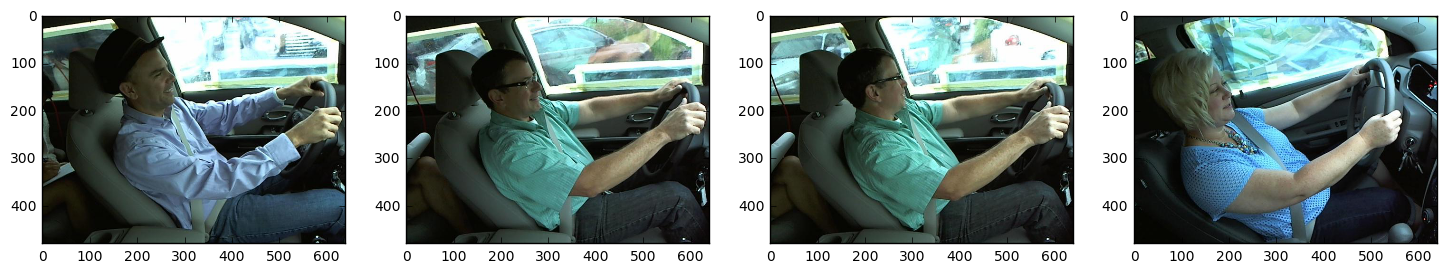

In [11]:
for i in range(1):
    fns = glob.glob(DATA_DIR_SAMPLE + 'train/c%i/*.jpg' % i)
    ims = [plt.imread(fn) for fn in fns[:4]]
    plot_4ims(ims)

#### Step 3: What needs to be done to preprocess the data for VGG?
- VGG has bgr instead of rgb --> in lambda preprocessing
- Subtract mean value (needs to be listed) --> In lambda preprocessing
- Has image shape 3x224x224 --> in get_batches

#### Step 4: Set up the Vgg16 model

In [7]:
# Create the Keras model
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.models import Sequential

model = Sequential()

In [8]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Total params: 0
____________________________________________________________________________________________________


In [9]:
# First step is preprocessing, so let's write a routine like in the Vgg class
import numpy as np
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    # x is the image (but in what format???)
    x = x - vgg_mean
    return x[:, ::-1]

So Vgg has input size3x224x224 (channels, width, height)

In [10]:
# Ok so, I don't get that yet, but we will continue...
# What is this lambda: Just applies a function I guess
from keras.layers.core import Lambda

In [11]:
model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))

So now we actually need to check out the model structure and build the model.

In [12]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [13]:
def add_conv_block(model, conv_layers, filters):
    for i in range(conv_layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [14]:
add_conv_block(model, 2, 64)
add_conv_block(model, 2, 128)
add_conv_block(model, 3, 256)
add_conv_block(model, 3, 512)
add_conv_block(model, 3, 512)

In [15]:
# Now transition to fully connected
from keras.layers.core import Flatten 
model.add(Flatten())

In [16]:
from keras.layers.core import Dense, Dropout
def add_fc_block(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [17]:
add_fc_block(model)
add_fc_block(model)

In [18]:
# The final softmax layer (will not use this in the end but probably need it to load the weights...)
model.add(Dense(1000, activation='softmax'))

In [19]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [20]:
# Now load the weights
from keras.utils.data_utils import get_file
fn = 'vgg16.h5'
model.load_weights(get_file(fn, 'http://files.fast.ai/models/' + fn, 
                            cache_subdir='models'))

In [21]:
# Let's also load the inital imagenet classes
import json
fn = 'imagenet_class_index.json'
# Aha the cache is in the .keras directory, clever
fpath = get_file(fn, 'http://files.fast.ai/models/' + fn, 
                 cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)

In [22]:
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [23]:
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

#### Step 5: Make a prediction with the raw model for the statefarm data

In [19]:
# Do this batches stuff
# so it works with this image data generator
from keras.preprocessing import image
gen = image.ImageDataGenerator()

In [25]:
batch_size = 64
test_batches = gen.flow_from_directory(DATA_DIR + 'test', target_size=(224, 224), 
                                       class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 79726 images belonging to 1 classes.


In [31]:
test_batches.nb_sample

79726

In [30]:
# Ok, so this takes forever so we will skip it for now

In [ ]:
preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [ ]:
preds.shape

In [ ]:
# Convert that to actual predictions and then plot
highest_idx = np.argmax(preds, axis=1)
preds_prob = [preds[i, highest_idx[i]] for i in range(len(highest_idx))]
highest_classes = [classes[i] for i in highest_idx] 

In [ ]:
ims, l = next(test_batches)

In [ ]:
ims.shape


In [ ]:
ims_list = [np.rollaxis(ims[i], 0, 3)[:, :, ::-1] for i in range(4)]
ims_list[0].shape

In [ ]:
plot_4ims(ims_list)
print(highest_classes[:4], preds_prob[:4])

Ok So I am not so sure what is going on with the colors. But hey I made a prediction... yay. Seatbelts..

### Step 5.5: Precompute the convolutional layers

In [20]:
layers = model.layers

In [21]:
last_conv_idx = [i for i, lyr in enumerate(layers) 
                 if type(lyr) == Convolution2D][-1]

In [22]:
last_conv_idx

30

In [23]:
type(layers[31])

keras.layers.pooling.MaxPooling2D

In [24]:
# So why not the MaxPooling layer as well? Not sure...
conv_layers = layers[:last_conv_idx + 1]
fc_layers = layers[last_conv_idx + 1:]

In [25]:
# Create a model just for the convolutional part
# DO NOT RUN THIS TWICE!!!
conv_model = Sequential(conv_layers)  # They are all not trainable...

In [32]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

In [26]:
# So now we can load the train and valid data and feed it to 
# the predict_generator. For this we need to set shuffle to false.
batch_size = 64
gen = image.ImageDataGenerator()   # No augmentation of course

In [52]:
train_batches = gen.flow_from_directory(
    DATA_DIR + 'train', 
    target_size=(224, 224), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False,
)
valid_batches = gen.flow_from_directory(
    DATA_DIR + 'valid', 
    target_size=(224, 224), 
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=False,
)

Found 19935 images belonging to 10 classes.
Found 2489 images belonging to 10 classes.


In [53]:
train_features = conv_model.predict_generator(
    train_batches,
    train_batches.nb_sample,
)

In [54]:
valid_features = conv_model.predict_generator(
    valid_batches,
    valid_batches.nb_sample,
)

In [27]:
# now I would like to save those so I can load them again tomorrow :)
# What is in the save_array function
import bcolz
def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [59]:
# Save to a model directory in the statefarm folder
model_path = DATA_DIR + '/models/'
%mkdir -p $model_path
save_array(model_path + 'train_convlayer_features.bc', train_features)
save_array(model_path + 'valid_convlayer_features.bc', valid_features)

In [24]:
# Also save the labels since I have a feeling they don't match up
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(train_batches.classes)
valid_labels = to_categorical(valid_batches.classes)

NameError: name 'train_batches' is not defined

In [61]:
save_array(model_path + 'train_convlayer_labels.bc', train_labels)
save_array(model_path + 'valid_convlayer_labels.bc', valid_labels)

In [34]:
# Now next time I can just do 
model_path = DATA_DIR + '/models/'
train_features = load_array(model_path + 'train_convlayer_features.bc')
valid_features = load_array(model_path + 'valid_convlayer_features.bc')
train_labels = load_array(model_path + 'train_convlayer_labels.bc')
valid_labels = load_array(model_path + 'valid_convlayer_labels.bc')

In [63]:
train_features.shape

(19935, 512, 14, 14)

#### Step 6: Modify the model for the new task
- Pop the last layer, preserve the rest and add a new final fully connected layer

In [82]:
# So now we can create a new model, let's first see whether 
# loading the weights is important for a network of this size
fc_model_weights = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten()])
add_fc_block(fc_model_weights)
add_fc_block(fc_model_weights)
fc_model_weights.add(Dense(1000, activation='softmax')) 

In [83]:
# Now load the weight for the fc_model from the fc_layers
for l1, l2 in zip(fc_model_weights.layers, fc_layers):
    l1.set_weights(l2.get_weights())

In [84]:
fc_model_weights.pop()
for l in fc_model_weights.layers:   # Just training the last layers
    l.trainable = False
fc_model_weights.add(Dense(10, activation='softmax'))

In [28]:
# Let's also use Adam!
from keras.optimizers import Adam, RMSprop
opt = Adam(lr=0.001)   # Default also recommended by GA
#  opt = RMSprop(lr=0.001, rho=0.7)

In [86]:
fc_model_weights.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [87]:
fc_model_weights.fit(
    train_features, 
    train_labels, 
    nb_epoch=10, 
    batch_size=batch_size,
    validation_data=(valid_features, valid_labels)
)

Train on 19935 samples, validate on 2489 samples
Epoch 1/10
19935/19935 [==============================] - 8s - loss: 1.8277 - acc: 0.4801 - val_loss: 1.7600 - val_acc: 0.4829
Epoch 2/10
19935/19935 [==============================] - 7s - loss: 0.9956 - acc: 0.6827 - val_loss: 1.7539 - val_acc: 0.4721
Epoch 3/10
19935/19935 [==============================] - 7s - loss: 0.8539 - acc: 0.7264 - val_loss: 1.7003 - val_acc: 0.4990
Epoch 4/10
19935/19935 [==============================] - 7s - loss: 0.8182 - acc: 0.7342 - val_loss: 1.9443 - val_acc: 0.4283
Epoch 5/10
19935/19935 [==============================] - 7s - loss: 0.7690 - acc: 0.7566 - val_loss: 1.8325 - val_acc: 0.4572
Epoch 6/10
19935/19935 [==============================] - 7s - loss: 0.7696 - acc: 0.7580 - val_loss: 1.7933 - val_acc: 0.4656
Epoch 7/10
19935/19935 [==============================] - 7s - loss: 0.7735 - acc: 0.7612 - val_loss: 2.0021 - val_acc: 0.4709
Epoch 8/10
19935/19935 [==============================] - 7s -

In [ ]:
for l in fc_model_weights.layers:   # Just training the last layers
    l.trainable = True

In [ ]:
fc_model_weights.fit(
    train_features, 
    train_labels, 
    nb_epoch=10, 
    batch_size=batch_size,
    validation_data=(valid_features, valid_labels)
)

In [88]:
# Now do the same without loading the weights
fc_model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten()])
add_fc_block(fc_model)
add_fc_block(fc_model)
fc_model.add(Dense(10, activation='softmax'))

fc_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [89]:
fc_model.fit(
    train_features, 
    train_labels, 
    nb_epoch=10, 
    batch_size=batch_size,
    validation_data=(valid_features, valid_labels)
)

Train on 19935 samples, validate on 2489 samples
Epoch 1/10
19935/19935 [==============================] - 33s - loss: 14.4391 - acc: 0.1040 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 2/10
19935/19935 [==============================] - 34s - loss: 14.4363 - acc: 0.1043 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 3/10
19935/19935 [==============================] - 34s - loss: 14.4396 - acc: 0.1041 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 4/10
19935/19935 [==============================] - 33s - loss: 14.4404 - acc: 0.1041 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 5/10
19935/19935 [==============================] - 33s - loss: 14.4372 - acc: 0.1043 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 6/10
19935/19935 [==============================] - 33s - loss: 14.4363 - acc: 0.1043 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 7/10
19935/19935 [==============================] - 33s - loss: 14.4404 - acc: 0.1041 - val_loss: 14.4927 - val_acc: 0.1008
Epoch 8/10
19935/19935 [=================

In [98]:
for l in fc_model.layers:
    print(l.trainable)

True
True
True
True
True
True
True


In [29]:
from keras.layers.normalization import BatchNormalization
p = 0.8
bn_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dropout(p),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense(10, activation='softmax')]
)

In [30]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
bn_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [41]:
batch_size = 64
bn_model.fit(
    train_features, 
    train_labels, 
    nb_epoch=5, 
    batch_size=batch_size,
    validation_data=(valid_features, valid_labels)
)

Train on 19935 samples, validate on 2489 samples
Epoch 1/5
19935/19935 [==============================] - 8s - loss: 2.9393 - acc: 0.2520 - val_loss: 1.2055 - val_acc: 0.6448
Epoch 2/5
19935/19935 [==============================] - 8s - loss: 1.1964 - acc: 0.5816 - val_loss: 0.9480 - val_acc: 0.6963
Epoch 3/5
19935/19935 [==============================] - 8s - loss: 0.7122 - acc: 0.7543 - val_loss: 0.8681 - val_acc: 0.7107
Epoch 4/5
19935/19935 [==============================] - 8s - loss: 0.5294 - acc: 0.8201 - val_loss: 0.8688 - val_acc: 0.7011
Epoch 5/5
19935/19935 [==============================] - 8s - loss: 0.4012 - acc: 0.8661 - val_loss: 0.9103 - val_acc: 0.7019


## BATCH NORM IS SO FREAKING IMPORTANT!!!

## Data augmentation

In [28]:
gen_da = image.ImageDataGenerator(
    rotation_range=15, 
    height_shift_range=0.05,
    shear_range=0.1, 
    channel_shift_range=20, 
    width_shift_range=0.1)

In [29]:
batch_size_da = 16
train_batches_da = gen_da.flow_from_directory(
    DATA_DIR + 'train', 
    target_size=(224, 224), 
    class_mode='categorical', 
    batch_size=batch_size_da,
    shuffle=False,
)

Found 19935 images belonging to 10 classes.


In [38]:
da_mult = 5   # 5 times more data
train_features_da = conv_model.predict_generator(
    train_batches_da,
    train_batches_da.nb_sample * 5,
)

In [39]:
save_array(model_path + 'train_convlayer_features_da.bc', train_features_da)

In [42]:
train_features_da = load_array(model_path + 'train_convlayer_features_da.bc')

In [47]:
train_features_da.shape

(99675, 512, 14, 14)

In [48]:
train_features.shape

(19935, 512, 14, 14)

In [54]:
new_shape = (train_features_da.shape[0] + train_features.shape[0], 521, 14, 14)

In [55]:
new_shape

(119610, 521, 14, 14)

In [58]:
train_features_da_orig = train_features_da
train_features_da_orig[:train_features.shape[0]] = train_features

In [59]:
train_labels_da_orig = np.concatenate([train_labels] * 5)

In [60]:
train_features_da_orig.shape

(99675, 512, 14, 14)

In [61]:
train_labels_da_orig.shape

(99675, 10)

In [ ]:
# More training with the augmented data

In [62]:
bn_model.fit(
    train_features_da_orig, 
    train_labels_da_orig, 
    nb_epoch=10, 
    batch_size=batch_size,
    validation_data=(valid_features, valid_labels)
)

Train on 99675 samples, validate on 2489 samples
Epoch 1/10
99675/99675 [==============================] - 40s - loss: 0.7535 - acc: 0.7559 - val_loss: 0.7461 - val_acc: 0.7509
Epoch 2/10
99675/99675 [==============================] - 39s - loss: 0.5355 - acc: 0.8278 - val_loss: 0.7729 - val_acc: 0.7453
Epoch 3/10
99675/99675 [==============================] - 39s - loss: 0.4651 - acc: 0.8508 - val_loss: 0.6875 - val_acc: 0.7726
Epoch 4/10
99675/99675 [==============================] - 39s - loss: 0.4207 - acc: 0.8668 - val_loss: 0.6919 - val_acc: 0.7734
Epoch 5/10
99675/99675 [==============================] - 39s - loss: 0.3924 - acc: 0.8759 - val_loss: 0.7225 - val_acc: 0.7766
Epoch 6/10
99675/99675 [==============================] - 39s - loss: 0.3653 - acc: 0.8856 - val_loss: 0.7360 - val_acc: 0.7790
Epoch 7/10
99675/99675 [==============================] - 39s - loss: 0.3485 - acc: 0.8892 - val_loss: 0.7119 - val_acc: 0.7826
Epoch 8/10
99675/99675 [==============================]

In [72]:
model_path = DATA_DIR + '/models/'
bn_model.save_weights(model_path + 'bn_model.h5')

In [31]:
model_path = DATA_DIR + '/models/'
bn_model.load_weights(model_path + 'bn_model.h5')

In [32]:
# Make predictions

In [33]:
batch_size = 64
test_batches = gen.flow_from_directory(
    DATA_DIR + 'test', 
    target_size=(224, 224), 
    class_mode='categorical', 
    shuffle=False, 
    batch_size=batch_size)

Found 79726 images belonging to 1 classes.


In [34]:
test_features = conv_model.predict_generator(test_batches,
                                             test_batches.nb_sample)

In [35]:
save_array(model_path + 'test_convlayer_features.bc', test_features)

In [36]:
preds = bn_model.predict(
    test_features,
    batch_size
)

In [42]:
save_array(model_path + 'preds_bn.bc', preds)

In [43]:
preds.shape

(79726, 10)

In [37]:
def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/9, mx)

In [38]:
clipped_preds = do_clip(preds, 0.93)

In [39]:
sub_ids = [int(fn.rstrip('.jpg').lstrip('unknown/img_')) for 
           fn in test_batches.filenames]
sub_ids = np.array(sub_ids)
sub_ids = np.reshape(sub_ids, (sub_ids.shape[0], 1))

In [40]:
sub_cols = np.append(sub_ids, clipped_preds, 1)

In [45]:
sub_fn = 'submission_nb_clipped.csv'
sub_dir = DATA_DIR + 'submission/'


In [46]:
np.savetxt(sub_dir + sub_fn, sub_cols, fmt='img_%d.jpg,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f',
           header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

In [36]:
preds[:5]

array([[  2.41000066e-07,   8.26859832e-06,   9.81846154e-01,
          2.39412951e-11,   4.15757199e-07,   3.24167693e-09,
          1.63959908e-06,   5.69432314e-06,   1.81276575e-02,
          9.88365446e-06],
       [  4.44128927e-05,   2.67515238e-02,   4.87249463e-06,
          1.38170589e-02,   1.00372185e-04,   9.54457402e-01,
          8.79563682e-04,   3.43926554e-03,   3.93975090e-04,
          1.11572794e-04],
       [  4.63191420e-01,   5.73637430e-03,   7.52565041e-02,
          8.73389933e-03,   4.77140211e-02,   3.92979302e-04,
          2.47573838e-01,   1.20372989e-03,   6.58392720e-03,
          1.43613204e-01],
       [  7.54156038e-02,   3.88742308e-03,   2.91085942e-03,
          1.50685579e-01,   2.67026812e-01,   8.34186736e-04,
          1.62800476e-02,   8.11378658e-03,   4.20546047e-02,
          4.32791084e-01],
       [  9.59997298e-04,   7.09374482e-03,   2.25981392e-04,
          1.42076295e-02,   5.04537858e-02,   2.62497342e-03,
          1.36437081e-02

In [37]:
sub_ids = [int(fn.rstrip('.jpg').lstrip('unknown/img_')) for 
           fn in test_batches.filenames]

In [38]:
preds.shape

(79726, 10)

In [39]:
sub_ids = np.array(sub_ids)

In [41]:
sub_ids = np.reshape(sub_ids, (sub_ids.shape[0], 1))

In [42]:
sub_cols = np.append(sub_ids, preds, 1)

In [43]:
sub_cols[:5]

array([[  8.16010000e+04,   2.41000066e-07,   8.26859832e-06,
          9.81846154e-01,   2.39412951e-11,   4.15757199e-07,
          3.24167693e-09,   1.63959908e-06,   5.69432314e-06,
          1.81276575e-02,   9.88365446e-06],
       [  1.48870000e+04,   4.44128927e-05,   2.67515238e-02,
          4.87249463e-06,   1.38170589e-02,   1.00372185e-04,
          9.54457402e-01,   8.79563682e-04,   3.43926554e-03,
          3.93975090e-04,   1.11572794e-04],
       [  6.28850000e+04,   4.63191420e-01,   5.73637430e-03,
          7.52565041e-02,   8.73389933e-03,   4.77140211e-02,
          3.92979302e-04,   2.47573838e-01,   1.20372989e-03,
          6.58392720e-03,   1.43613204e-01],
       [  4.51250000e+04,   7.54156038e-02,   3.88742308e-03,
          2.91085942e-03,   1.50685579e-01,   2.67026812e-01,
          8.34186736e-04,   1.62800476e-02,   8.11378658e-03,
          4.20546047e-02,   4.32791084e-01],
       [  2.26330000e+04,   9.59997298e-04,   7.09374482e-03,
          2.25

In [44]:
sub_fn = 'submission1.csv'
%mkdir -p $DATA_DIR/submission

In [54]:
sub_dir = '/home/ubuntu/courses/submissions/statefarm/'
np.savetxt(sub_dir + sub_fn, sub_cols, fmt='img_%d.jpg,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f',
           header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

In [56]:
# So this gets me a log loss of 5.8, pretty much last in the leaderboard
# Now let's retrain cut the predictions and see
preds_clip = preds.clip(min=0.05, max=0.95)

In [57]:
sub_cols = np.append(sub_ids, preds_clip, 1)

In [58]:
sub_fn = 'submission1_clip.csv'
np.savetxt(sub_dir + sub_fn, sub_cols, fmt='img_%d.jpg,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f',
           header='img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9', comments='')

In [59]:
# Ok, log loss 2.8
# Let's now try retraining more layers with more epochs.

In [60]:
layers = model.layers

In [62]:
first_dense_idx = [index for index, layer in enumerate(layers) if type(layer) is Dense][0]

In [65]:
for layer in layers[first_dense_idx:]:
    layer.trainable = True

In [69]:
model.fit_generator(train_batches, train_batches.nb_sample, 5, 
                    validation_data=valid_batches, nb_val_samples=valid_batches.nb_sample)

Epoch 1/5
18424/18424 [==============================] - 534s - loss: 0.8567 - acc: 0.7309 - val_loss: 0.2819 - val_acc: 0.9180
Epoch 2/5
18424/18424 [==============================] - 533s - loss: 0.8499 - acc: 0.7337 - val_loss: 0.2448 - val_acc: 0.9313
Epoch 3/5
18424/18424 [==============================] - 534s - loss: 0.8505 - acc: 0.7428 - val_loss: 0.2446 - val_acc: 0.9297
Epoch 4/5
18424/18424 [==============================] - 534s - loss: 0.8292 - acc: 0.7464 - val_loss: 0.2321 - val_acc: 0.9317
Epoch 5/5
18424/18424 [==============================] - 534s - loss: 0.8469 - acc: 0.7398 - val_loss: 0.2051 - val_acc: 0.9417


In [70]:
model.save_weights(model_path + 'dense_layers1.h5')
model.save(model_path + 'full_model_dense_layers1.h5')